In [1]:
import tweepy
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from collections import Counter
import pickle as pkl
import os

In [2]:
def plot(data=list(), filename=str(), topn=int(), titles=list(), xlabel=str(), ylabel=str(), ymax=int(),legend=False):
    fig, axes = plt.subplots(1, 2, dpi=140, figsize=(15,5))
    [x.head(topn).plot(kind='bar', ax=axes[i]) for i,x in enumerate(data)]
    [ax.legend().set_visible(legend) for ax in axes]
    [ax.set_title(title) for ax,title in zip(axes,titles)]
    [ax.set_xlabel(xlabel) for ax in axes]
    [ax.set_ylabel(ylabel) for ax in axes]
    [ax.set_ylim(0, ymax) for ax in axes]
    plt.rcParams['savefig.facecolor']='white'
    plt.tight_layout()
    plt.savefig(filename,dpi=400, bbox_inches='tight')

Download the data from twitter in Dutch and Spanish with the #Trump, dont download it if you have the .csv files. Load those in the cell below this one

In [3]:
# The API-Key and the API-secret were displayed to you after you registered
API_KEY = 'CMVbbKW3qlYrNjeol8nE7qyk4'
API_SECRET = 'JmiBkatpuUA9I92ZKznin69Y9elODwTqCqyTTMPMFfTj6CrDs1'
ACCESS_TOKEN = '1413630811656622088-lHsFvx5qbW2xFiubSH41dPuGZ2IVbO'
ACCESS_SECRET = 'AivMHCufTSkJwqjKu66SFwigVQ0vYumzrACu9cFu7FcFE'

# Setup the authentication with your Twitter credentials:
auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
# Create the api to connect to Twitter using your authentication 
api = tweepy.API(auth, wait_on_rate_limit=True)

# Here is where the tweets are scraped, we want 500 tweets in spanish and then in dutch
max_tweets = 500
query = "(#trump OR #trump2022 OR #Trump OR #Trump2022 OR #Trump2020 OR #trump2020) AND (lang:nl)-filter:retweets"
nl_searcher = list(tweepy.Cursor(api.search_tweets, q=query).items(max_tweets))

query = "(#trump OR #trump2022 OR #Trump OR #Trump2022 OR #Trump2020 OR #trump2020) AND (lang:es)-filter:retweets"
es_searcher = list(tweepy.Cursor(api.search_tweets, q=query).items(max_tweets))

# Process the tweets and neatly place them in a dataframe
nlData = {"id": [], "created_at":[], "text": [], 'source': [], 'userID':[], 'name':[], 'username': [], 'location': [], 'userDescription': []}
esData = {"id": [], "created_at":[], "text": [], 'source': [], 'userID':[], 'name':[], 'username': [], 'location': [], 'userDescription': []}
for nl, es in zip(nl_searcher, es_searcher):
    # Set the dutch tweet data
    nlData['id'].append(nl.id)
    nlData['created_at'].append(nl.created_at)
    nlData['text'].append(nl.text)
    nlData['source'].append(nl.source)
    nlData['userID'].append(nl.user.id)
    nlData['name'].append(nl.user.name)
    nlData['username'].append(nl.user.screen_name)
    nlData['location'].append(nl.user.location)
    nlData['userDescription'].append(nl.user.description)
    # Set the pt tweet data
    esData['id'].append(es.id)
    esData['created_at'].append(es.created_at)
    esData['text'].append(es.text)
    esData['source'].append(es.source)
    esData['userID'].append(es.user.id)
    esData['name'].append(es.user.name)
    esData['username'].append(es.user.screen_name)
    esData['location'].append(es.user.location)
    esData['userDescription'].append(es.user.description)
nlDF = pd.DataFrame.from_dict(nlData)
esDF = pd.DataFrame.from_dict(esData)

# Write the tweets to disk
nlDF.to_csv("./nlDataset.csv")
esDF.to_csv("./esDataset.csv")

The folder of the .txt docs for the assignment

In [4]:
if not os.path.exists("./es"):
    os.mkdir("./es")
if not os.path.exists("./nl"):
    os.mkdir("./nl")
for row in nlDF.iterrows():
    with open("./nl/"+str(row[0])+".txt","w") as file_:
        file_.writelines("\n".join([str(x) for x in row[1][1:]]))

for row in esDF.iterrows():
    with open("./es/"+str(row[0])+".txt","w") as file_:
        file_.writelines("\n".join([str(x) for x in row[1][1:]]))

Load the dataframes with the tweets

In [5]:
nlDF = pd.read_csv("./data/nlDataset.csv")
esDF = pd.read_csv("./data/esDataset.csv")

Download the NLP algo for the languages

In [6]:
import pandas as pd
import stanza

stanza.download("nl")
nlNLP = stanza.Pipeline("nl")
stanza.download("es")
esNLP = stanza.Pipeline("es")

2022-11-18 21:14:01 INFO: Downloading default packages for language: nl (Dutch) ...
2022-11-18 21:14:02 INFO: File exists: /home/revess/stanza_resources/nl/default.zip
2022-11-18 21:14:06 INFO: Finished downloading models and saved to /home/revess/stanza_resources.
2022-11-18 21:14:06 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-18 21:14:07 INFO: Loading these models for language: nl (Dutch):
| Processor | Package |
-----------------------
| tokenize  | alpino  |
| pos       | alpino  |
| lemma     | alpino  |
| depparse  | alpino  |
| ner       | conll02 |

2022-11-18 21:14:07 INFO: Use device: cpu
2022-11-18 21:14:07 INFO: Loading: tokenize
2022-11-18 21:14:07 INFO: Loading: pos
2022-11-18 21:14:07 INFO: Loading: lemma
2022-11-18 21:14:07 INFO: Loading: depparse
2022-11-18 21:14:07 INFO: Loading: ner
2022-11-18 21:14:08 INFO: Done loading processors!


2022-11-18 21:14:08 INFO: Downloading default packages for language: es (Spanish) ...
2022-11-18 21:14:10 INFO: File exists: /home/revess/stanza_resources/es/default.zip
2022-11-18 21:14:14 INFO: Finished downloading models and saved to /home/revess/stanza_resources.
2022-11-18 21:14:14 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-18 21:14:16 INFO: Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| depparse     | ancora   |
| sentiment    | tass2020 |
| constituency | combined |
| ner          | conll02  |

2022-11-18 21:14:16 INFO: Use device: cpu
2022-11-18 21:14:16 INFO: Loading: tokenize
2022-11-18 21:14:16 INFO: Loading: mwt
2022-11-18 21:14:16 INFO: Loading: pos
2022-11-18 21:14:16 INFO: Loading: lemma
2022-11-18 21:14:16 INFO: Loading: depparse
2022-11-18 21:14:16 INFO: Loading: sentiment
2022-11-18 21:14:17 INFO: Loading: constituency
2022-11-18 21:14:18 INFO: Loading: ner
2022-11-18 21:14:18 INFO: Done loading processors!


Do Some preprocesssing and store the models

In [7]:
nlTweets = nlNLP(" ".join(nlDF["text"]))
esTweets = nlNLP(" ".join(esDF["text"]))

Statistics

Normal distribution of Tweet Length per language, we can see that Spanish overall uses more words than Dutch to express themselves about Trump

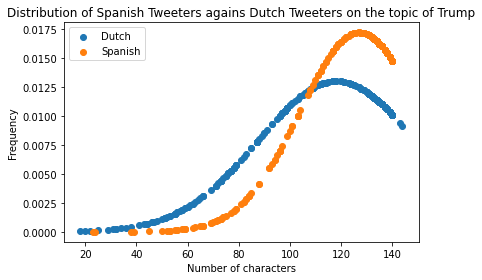

In [8]:
nlLengths = [len(x) for x in nlDF["text"]]
esLengths = [len(x) for x in esDF["text"]]
plt.scatter(nlLengths, stats.norm.pdf(nlLengths, statistics.mean(nlLengths), statistics.stdev(nlLengths)), label="Dutch")
plt.scatter(esLengths, stats.norm.pdf(esLengths, statistics.mean(esLengths), statistics.stdev(esLengths)), label="Spanish")
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Number of characters")
plt.title("Distribution of Spanish Tweeters agains Dutch Tweeters on the topic of Trump")
plt.rcParams['savefig.facecolor']='white'
plt.tight_layout()
plt.savefig("./plots/distros.png",dpi=400, bbox_inches='tight')

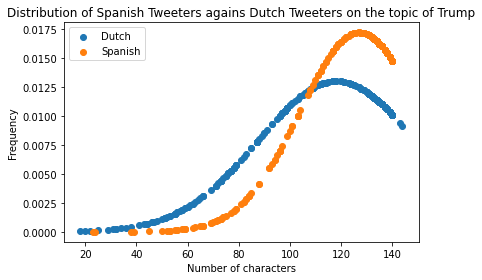

In [9]:
nlLengths = [len(x) for x in nlDF["text"]]
esLengths = [len(x) for x in esDF["text"]]
plt.scatter(nlLengths, stats.norm.pdf(nlLengths, statistics.mean(nlLengths), statistics.stdev(nlLengths)), label="Dutch")
plt.scatter(esLengths, stats.norm.pdf(esLengths, statistics.mean(esLengths), statistics.stdev(esLengths)), label="Spanish")
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Number of characters")
plt.title("Distribution of Spanish Tweeters agains Dutch Tweeters on the topic of Trump")
plt.rcParams['savefig.facecolor']='white'
plt.tight_layout()
plt.savefig("./plots/distros.png",dpi=400, bbox_inches='tight')

Lets look at the distribution of users in our dataset of the Dutch, only the top 20

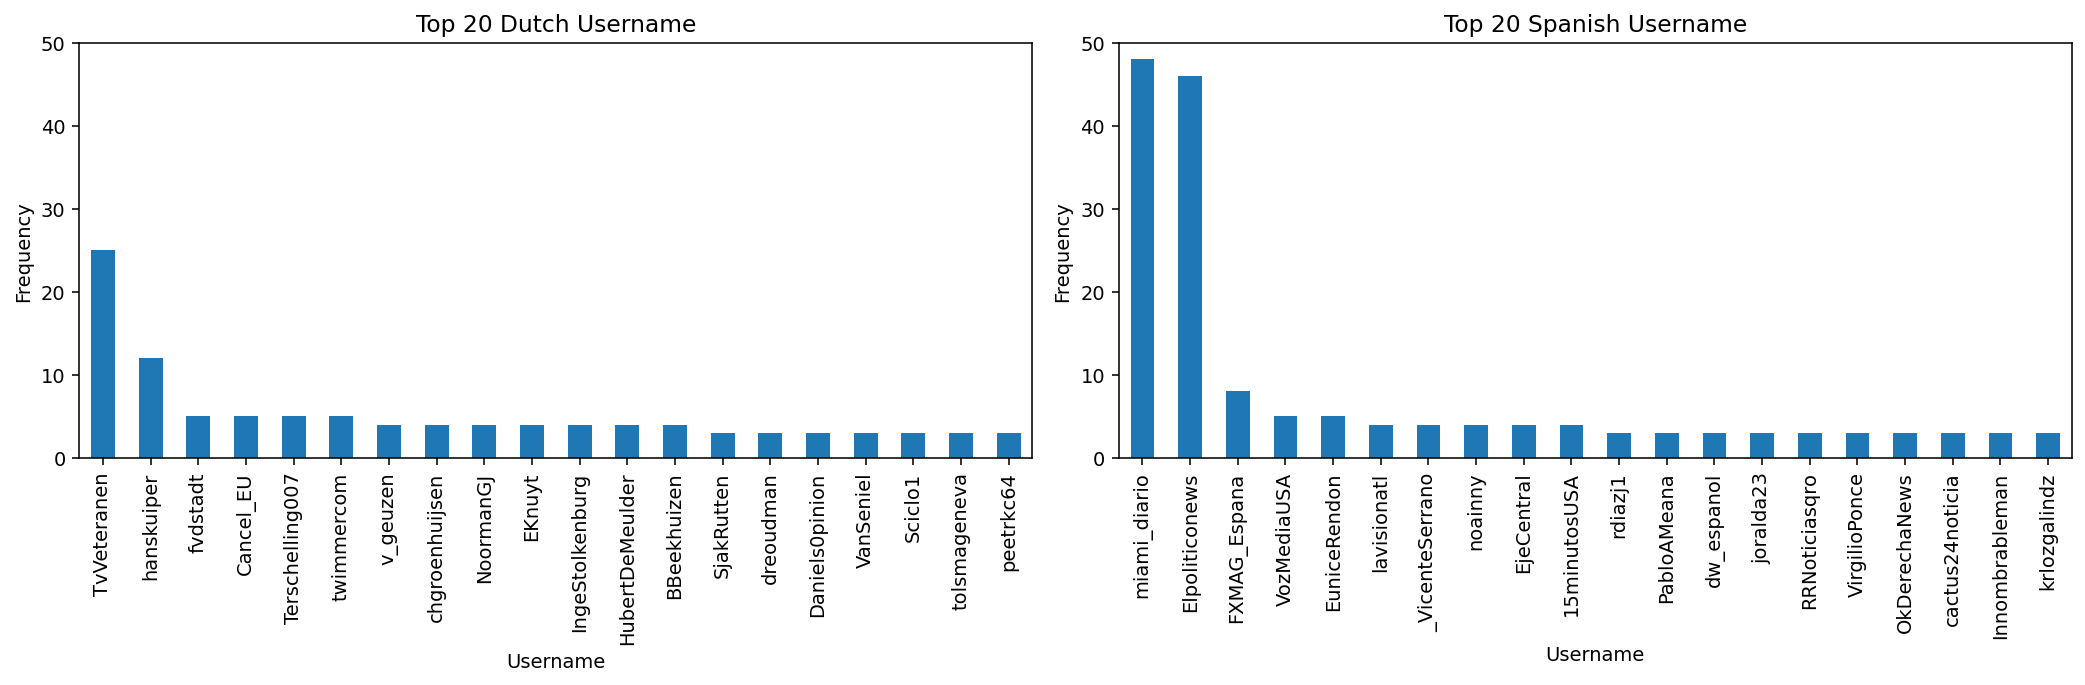

In [10]:
plot(
    data=[
        pd.DataFrame.from_dict(Counter(nlDF["username"]), orient='index').sort_values([0], ascending=False),
        pd.DataFrame.from_dict(Counter(esDF["username"]), orient='index').sort_values([0], ascending=False)],
    filename="./plots/Usernames.png",
    topn=20, 
    titles=["Top 20 Dutch Username","Top 20 Spanish Username"], 
    xlabel="Username", 
    ylabel="Frequency", 
    ymax=50
)

Here we can setup all our processing needs,
SPANISH STOPWORDS = https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
DUTCH STOPWORDS = https://github.com/stopwords-iso/stopwords-nl/blob/master/stopwords-nl.txt

In [11]:
from collections import Counter
functionalTokens = ['@','#','.',',',"'",'"','/','\\','?','!',":",";"] #Ignore these tokens
with open("./data/dutchStopwords.txt", "r") as file_:
    nlStopwords = file_.read().splitlines()
with open("./data/spanishStopwords.txt", "r") as file_:
    esStopwords = file_.read().splitlines()
nGrams = 2

nlTokenFrequencies = Counter() #setup a counter
nlLemmaFrequencies = Counter() #setup a counter
nlPOSlemma = Counter()
nlNGRAMS = Counter()
nlNGRAMSFiltered = Counter()
for sentence in nlTweets.sentences:
    nlTokenFrequencies.update([token.text for token in sentence.tokens if token.text not in functionalTokens])
    nlLemmaFrequencies.update([token.lemma for token in sentence.words if token.lemma not in functionalTokens])
    nlPOSlemma.update([word.pos for word in sentence.words if word.lemma not in functionalTokens])

    tokens = [token.text for token in sentence.tokens]
    nlNGRAMS.update([" ".join(tokens[i:i+nGrams]) for i in range(len(tokens)-nGrams+1)])
    tokens = [token.text for token in sentence.tokens if token.text not in nlStopwords ]
    nlNGRAMSFiltered.update([" ".join(tokens[i:i+nGrams]) for i in range(len(tokens)-nGrams+1)])


esTokenFrequencies = Counter() #setup a counter
esLemmaFrequencies = Counter() #setup a counter
esPOSlemma = Counter()
esNGRAMS = Counter()
esNGRAMSFiltered = Counter()
for sentence in esTweets.sentences:
    esTokenFrequencies.update([token.text for token in sentence.tokens if token.text not in functionalTokens])
    esLemmaFrequencies.update([token.lemma for token in sentence.words if token.lemma not in functionalTokens])
    esPOSlemma.update([word.pos for word in sentence.words if word.lemma not in functionalTokens])

    tokens = [token.text for token in sentence.tokens]
    esNGRAMS.update([" ".join(tokens[i:i+nGrams]) for i in range(len(tokens)-nGrams+1)])
    tokens = [token.text for token in sentence.tokens if token.text not in esStopwords ]
    esNGRAMSFiltered.update([" ".join(tokens[i:i+nGrams]) for i in range(len(tokens)-nGrams+1)])


You can store the processed tokens and its frequencies

In [12]:
with open("./data/nlData.pkl", "wb") as file_:
    pkl.dump([nlTokenFrequencies, nlLemmaFrequencies, nlPOSlemma, nlNGRAMS, nlNGRAMSFiltered, nlTweets],file_)
    
with open("./data/esData.pkl", "wb") as file_:
    pkl.dump([esTokenFrequencies, esLemmaFrequencies, esPOSlemma, esNGRAMS, esNGRAMSFiltered, esTweets],file_)

Plot tokens

/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: 

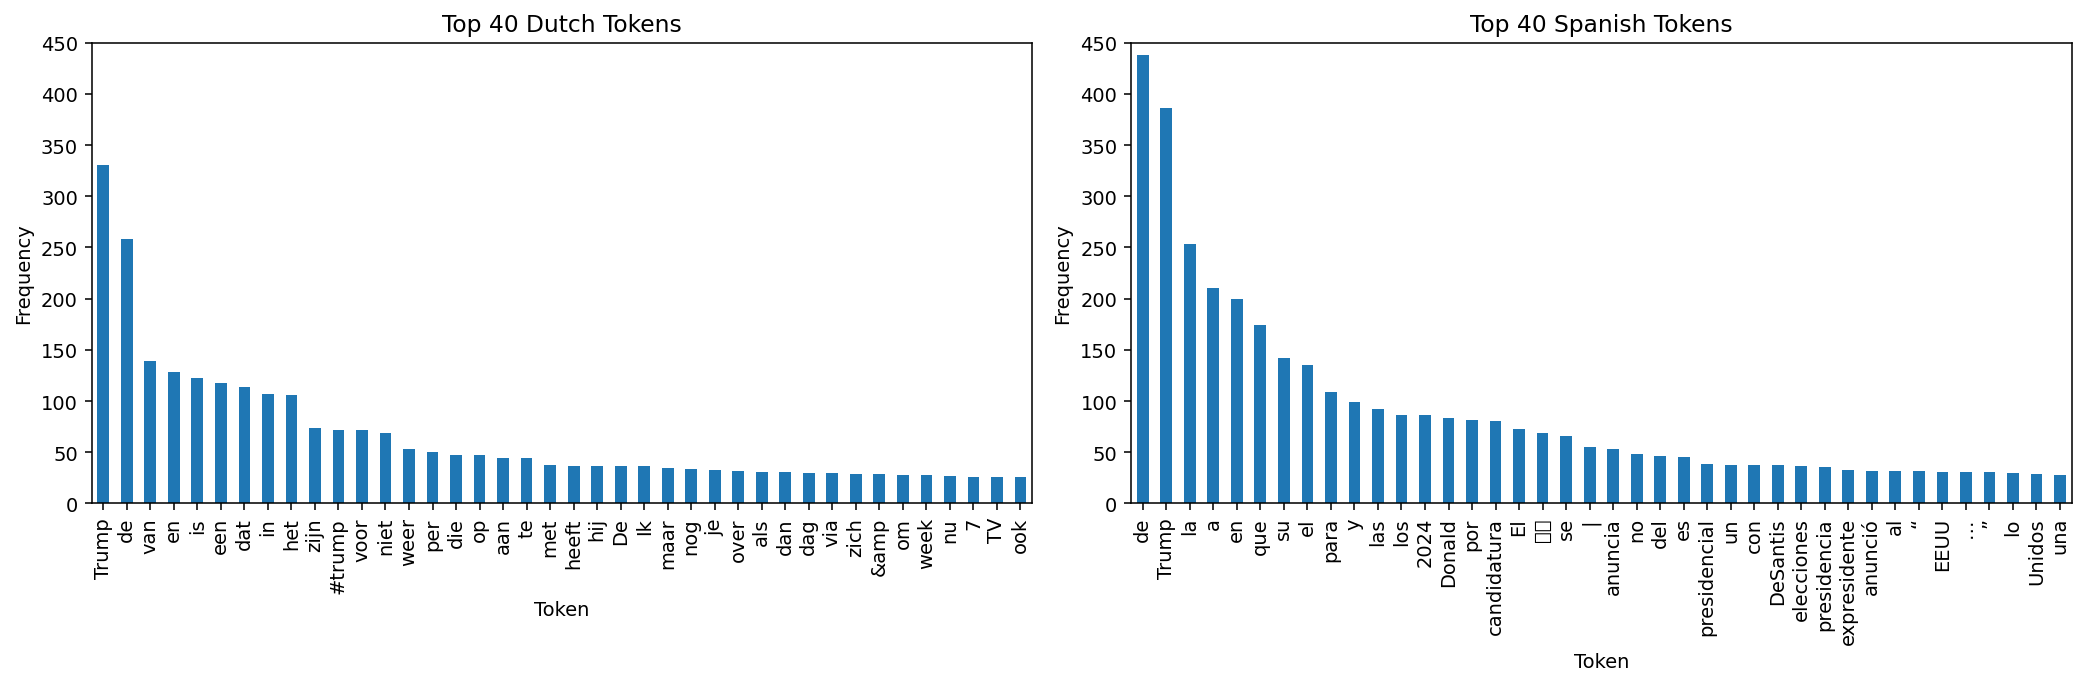

In [13]:
plot(
    data=[
        pd.DataFrame.from_dict(nlTokenFrequencies, orient='index').sort_values([0], ascending=False),
        pd.DataFrame.from_dict(esTokenFrequencies, orient='index').sort_values([0], ascending=False)],
    filename="./plots/tokens.png",
    topn=40, 
    titles=["Top 40 Dutch Tokens","Top 40 Spanish Tokens"], 
    xlabel="Token", 
    ylabel="Frequency", 
    ymax=450
)

LEMMAS

/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: 

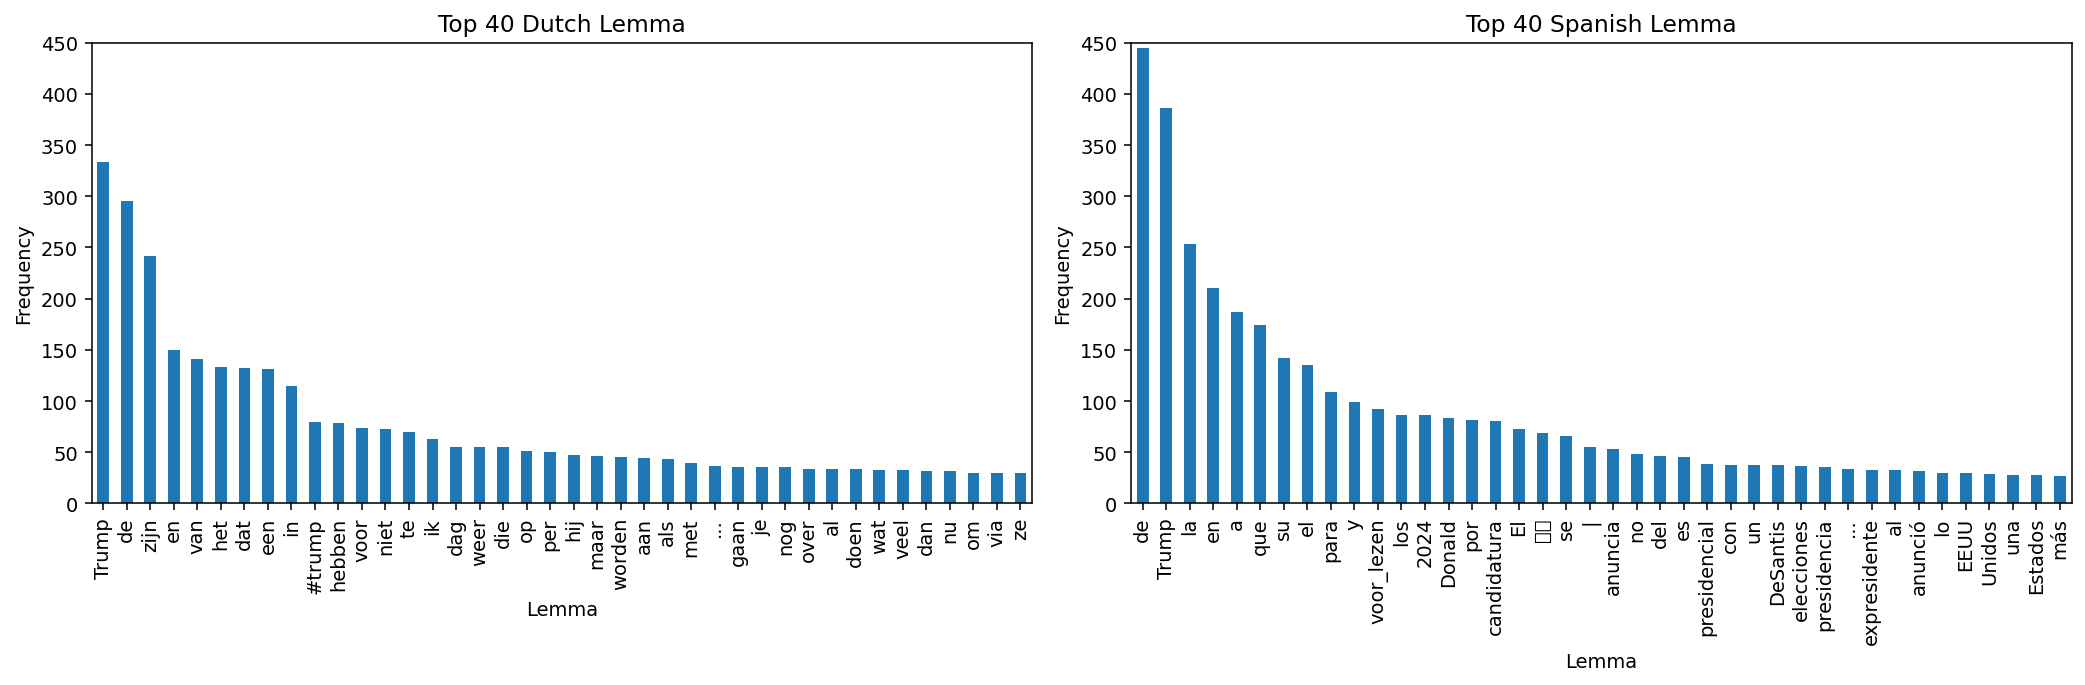

In [14]:
plot(
    data=[
        pd.DataFrame.from_dict(nlLemmaFrequencies, orient='index').sort_values([0], ascending=False),
        pd.DataFrame.from_dict(esLemmaFrequencies, orient='index').sort_values([0], ascending=False)],
    filename="./plots/Lemma.png",
    topn=40, 
    titles=["Top 40 Dutch Lemma","Top 40 Spanish Lemma"], 
    xlabel="Lemma", 
    ylabel="Frequency", 
    ymax=450
)

LEMMA VS TOKEN

/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: 

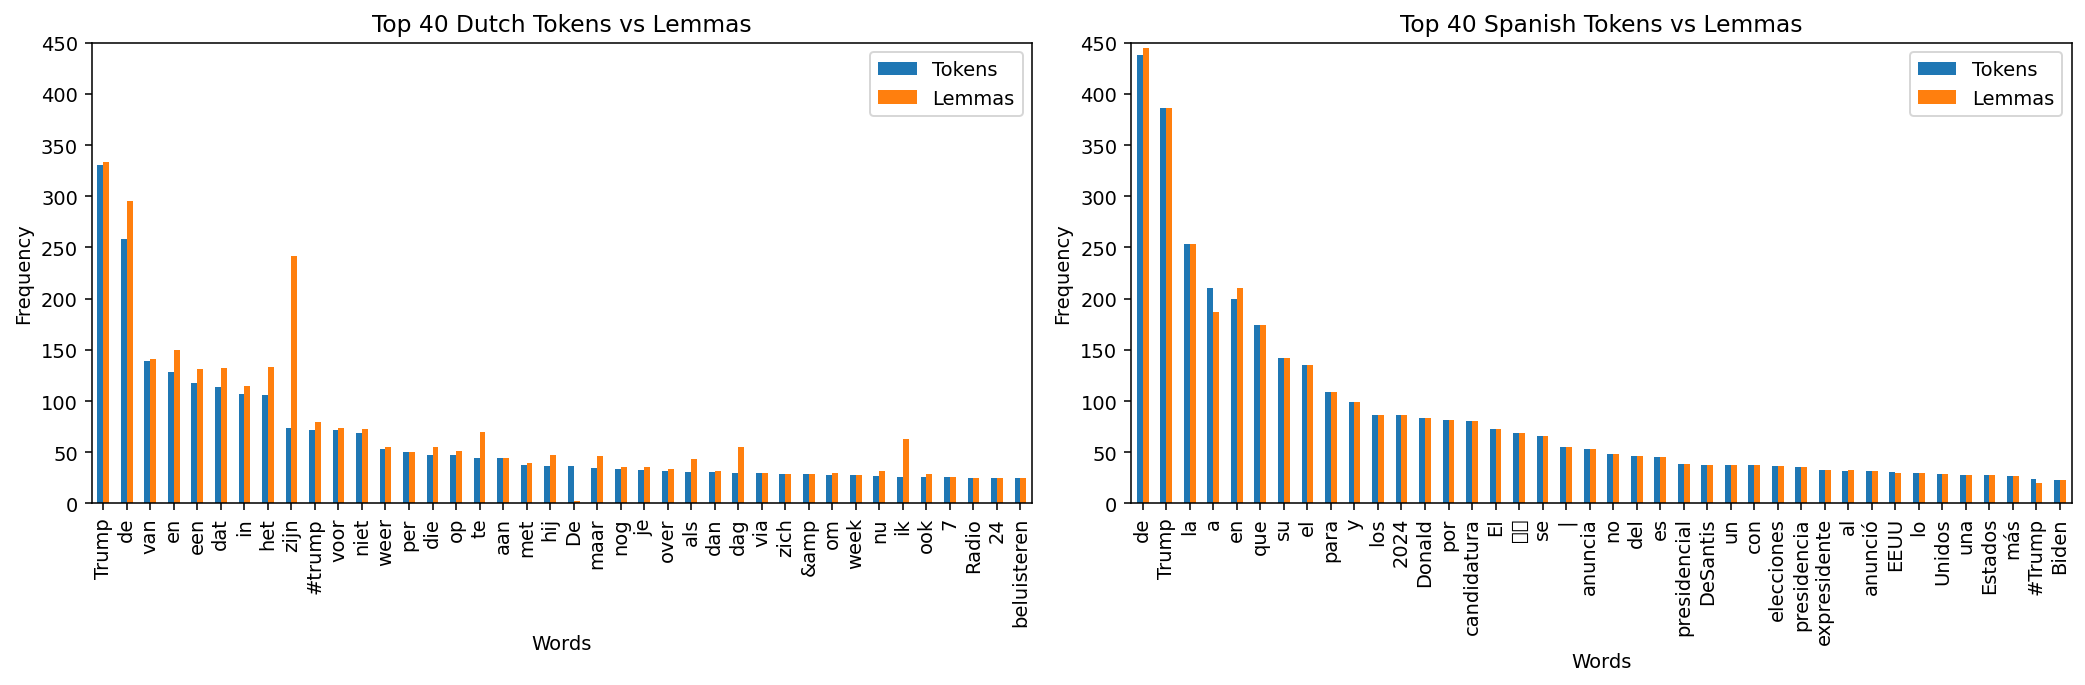

In [15]:
plot(
    data=[
        pd.concat([pd.DataFrame.from_dict(nlTokenFrequencies, orient='index', columns=["Tokens"]),pd.DataFrame.from_dict(nlLemmaFrequencies, orient='index', columns=["Lemmas"])],axis=1,sort=False).dropna().sort_values(["Tokens", "Lemmas"], ascending=False),
        pd.concat([pd.DataFrame.from_dict(esTokenFrequencies, orient='index', columns=["Tokens"]),pd.DataFrame.from_dict(esLemmaFrequencies, orient='index', columns=["Lemmas"])],axis=1,sort=False).dropna().sort_values(["Tokens", "Lemmas"], ascending=False)],
    filename="./plots/LemmavsToken.png",
    topn=40, 
    titles=["Top 40 Dutch Tokens vs Lemmas","Top 40 Spanish Tokens vs Lemmas"], 
    xlabel="Words", 
    ylabel="Frequency", 
    ymax=450,
    legend=True
)

POS

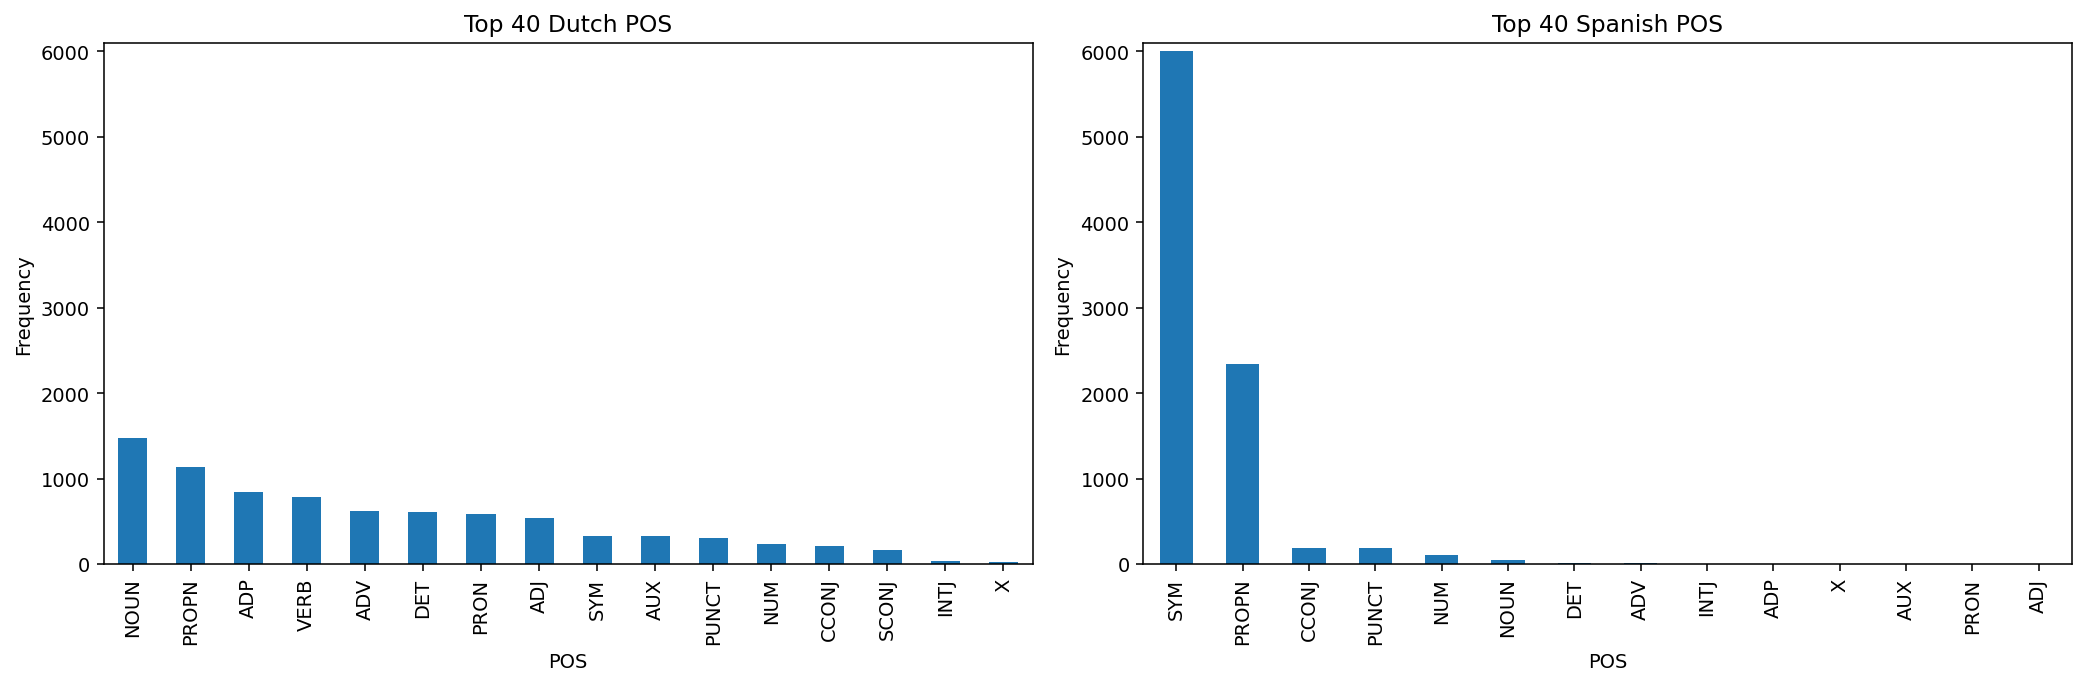

In [16]:
plot(
    data=[
        pd.DataFrame.from_dict(nlPOSlemma, orient='index').sort_values([0], ascending=False),
        pd.DataFrame.from_dict(esPOSlemma, orient='index').sort_values([0], ascending=False)],
    filename="./plots/pos.png",
    topn=40, 
    titles=["Top 40 Dutch POS","Top 40 Spanish POS"], 
    xlabel="POS", 
    ylabel="Frequency", 
    ymax=6100
)

NGRAMS

/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: 

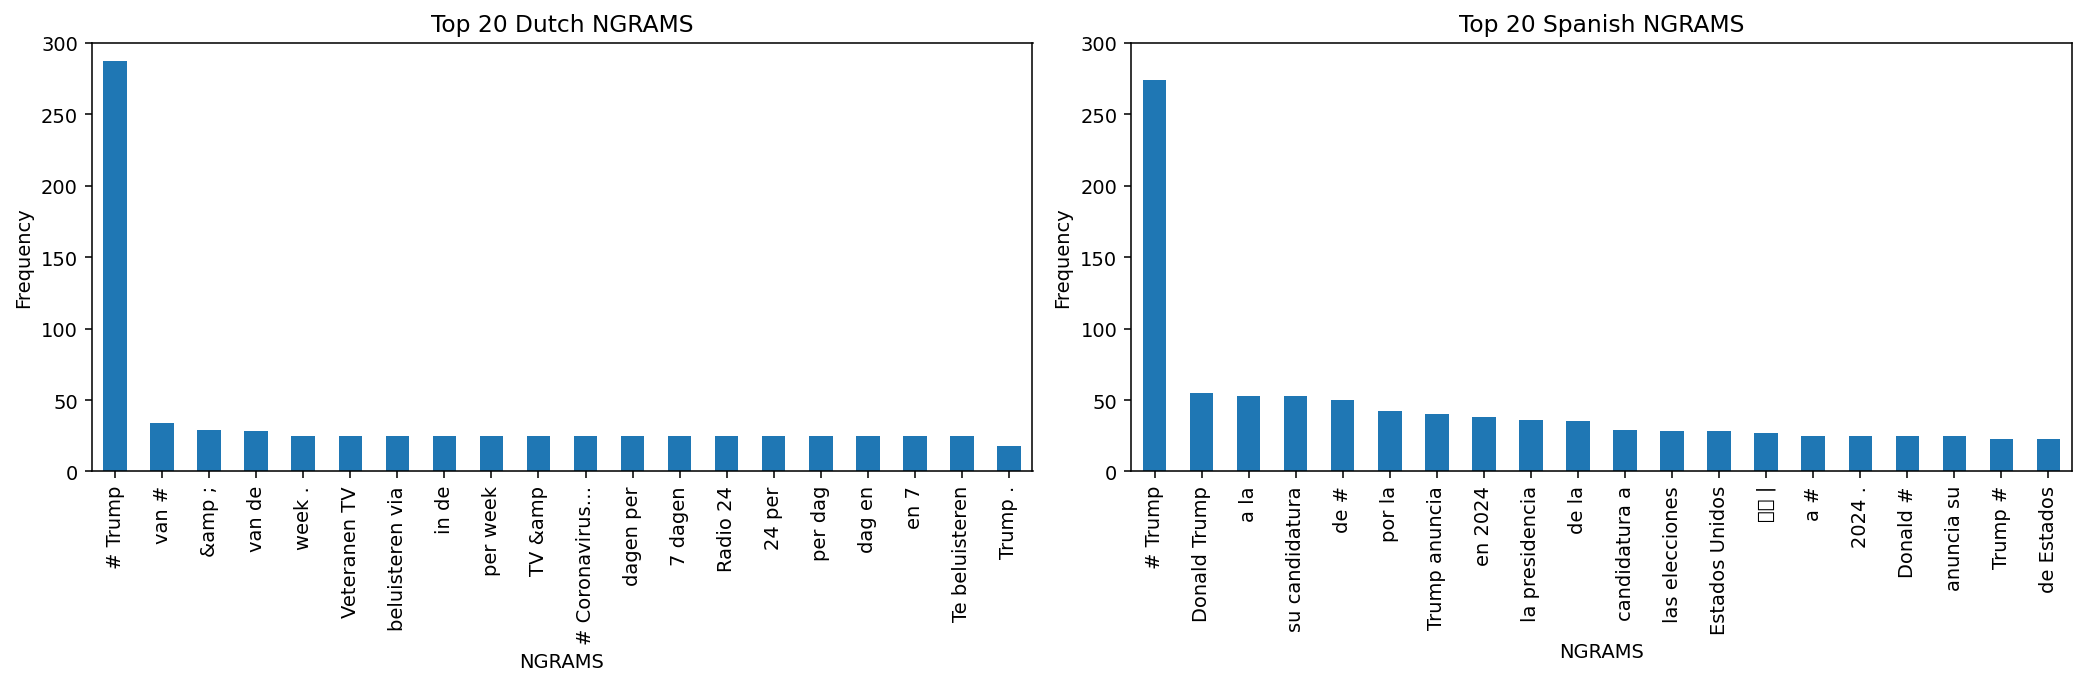

In [17]:
plot(
    data=[
        pd.DataFrame.from_dict(nlNGRAMS, orient='index').sort_values([0], ascending=False),
        pd.DataFrame.from_dict(esNGRAMS, orient='index').sort_values([0], ascending=False)],
    filename="./plots/ngrams.png",
    topn=20, 
    titles=["Top 20 Dutch NGRAMS","Top 20 Spanish NGRAMS"], 
    xlabel="NGRAMS", 
    ylabel="Frequency", 
    ymax=300
)

NGRAMS STOPWORDS FILTERED

/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: 

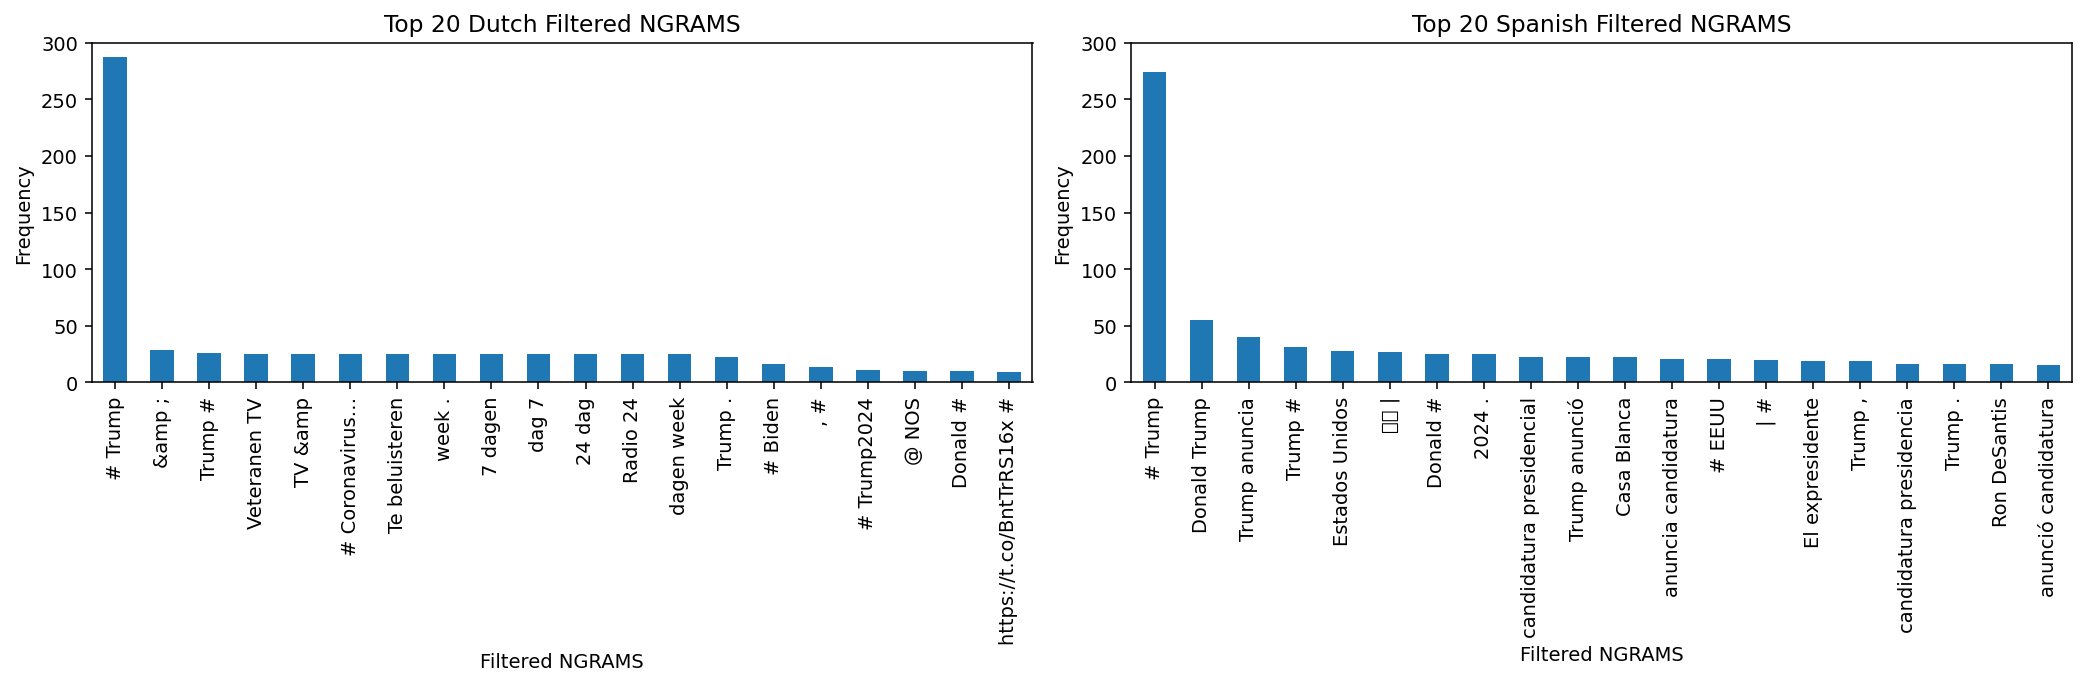

In [18]:
plot(
    data=[
        pd.DataFrame.from_dict(nlNGRAMSFiltered, orient='index').sort_values([0], ascending=False),
        pd.DataFrame.from_dict(esNGRAMSFiltered, orient='index').sort_values([0], ascending=False)],
    filename="./plots/ngramsfiltered.png",
    topn=20, 
    titles=["Top 20 Dutch Filtered NGRAMS","Top 20 Spanish Filtered NGRAMS"], 
    xlabel="Filtered NGRAMS", 
    ylabel="Frequency", 
    ymax=300
)

NGRAMS with and without stopwords

/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:10: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/tmp/ipykernel_70310/3618280118.py:11: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.savefig(filename,dpi=400, bbox_inches='tight')
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: 

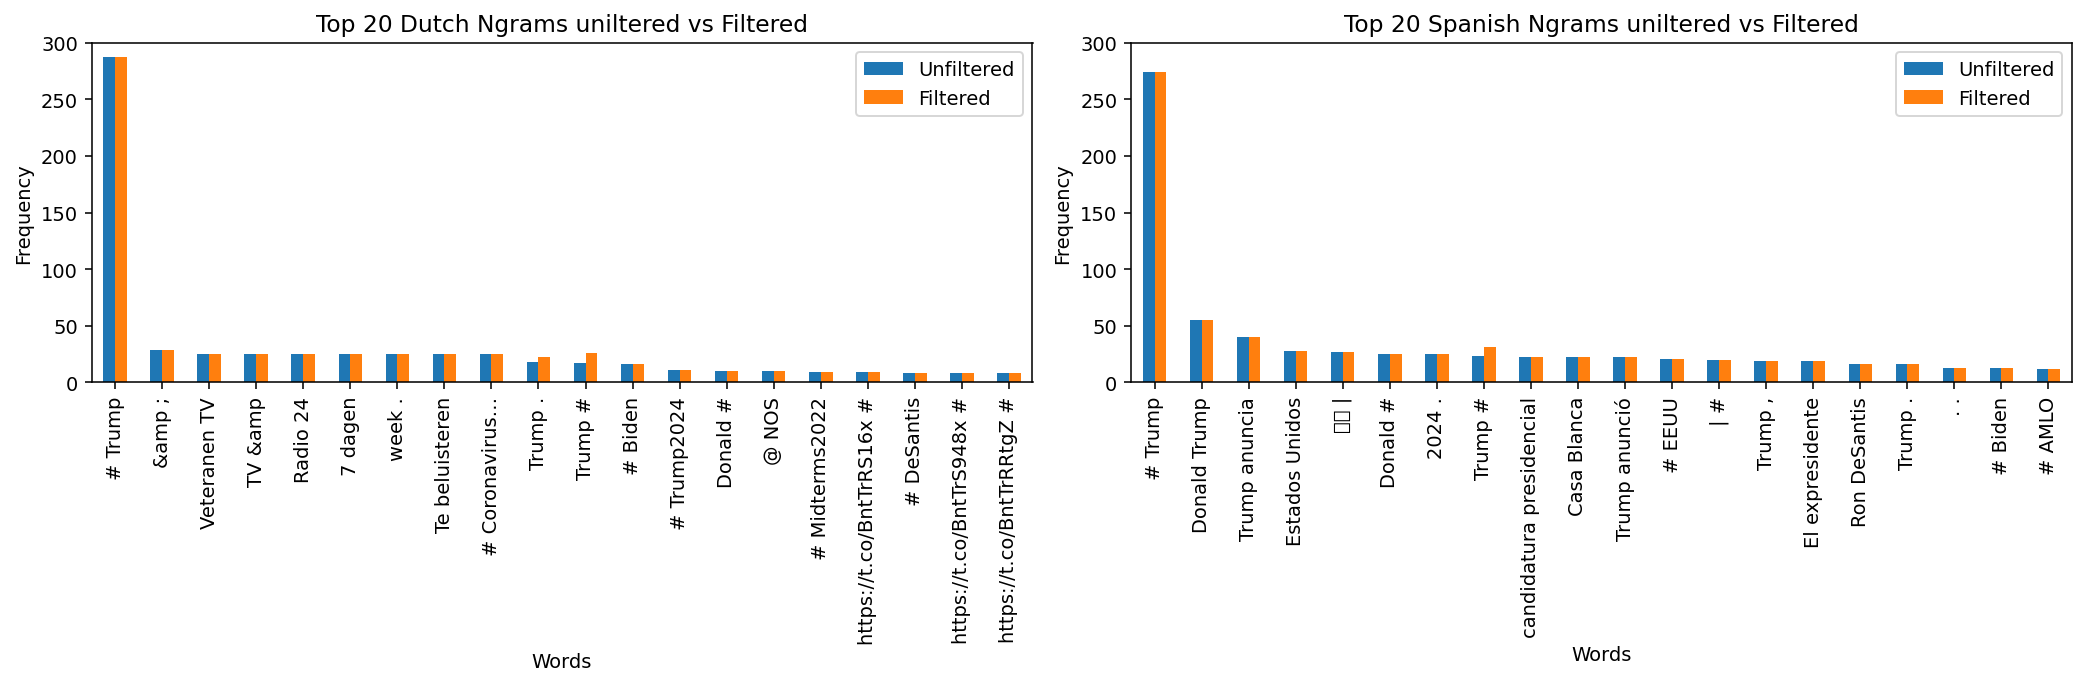

In [19]:
plot(
    data=[
        pd.concat([pd.DataFrame.from_dict(nlNGRAMS, orient='index', columns=["Unfiltered"]),pd.DataFrame.from_dict(nlNGRAMSFiltered, orient='index', columns=["Filtered"])],axis=1,sort=False).dropna().sort_values(["Unfiltered", "Filtered"], ascending=False),
        pd.concat([pd.DataFrame.from_dict(esNGRAMS, orient='index', columns=["Unfiltered"]),pd.DataFrame.from_dict(esNGRAMSFiltered, orient='index', columns=["Filtered"])],axis=1,sort=False).dropna().sort_values(["Unfiltered", "Filtered"], ascending=False)],
    filename="./plots/ngramsunfiltered_vs_filtered.png",
    topn=20, 
    titles=["Top 20 Dutch Ngrams uniltered vs Filtered","Top 20 Spanish Ngrams uniltered vs Filtered"], 
    xlabel="Words", 
    ylabel="Frequency", 
    ymax=300,
    legend=True
)

Here we analyze the number of tweets per token (and the tweet length statistics)

/tmp/ipykernel_70310/4293141237.py:72: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/4293141237.py:72: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/4293141237.py:73: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.savefig("./plots/Tweetspertoken.png",dpi=400, bbox_inches='tight')
/tmp/ipykernel_70310/4293141237.py:73: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.savefig("./plots/Tweetspertoken.png",dpi=400, bbox_inches='tight')
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-p

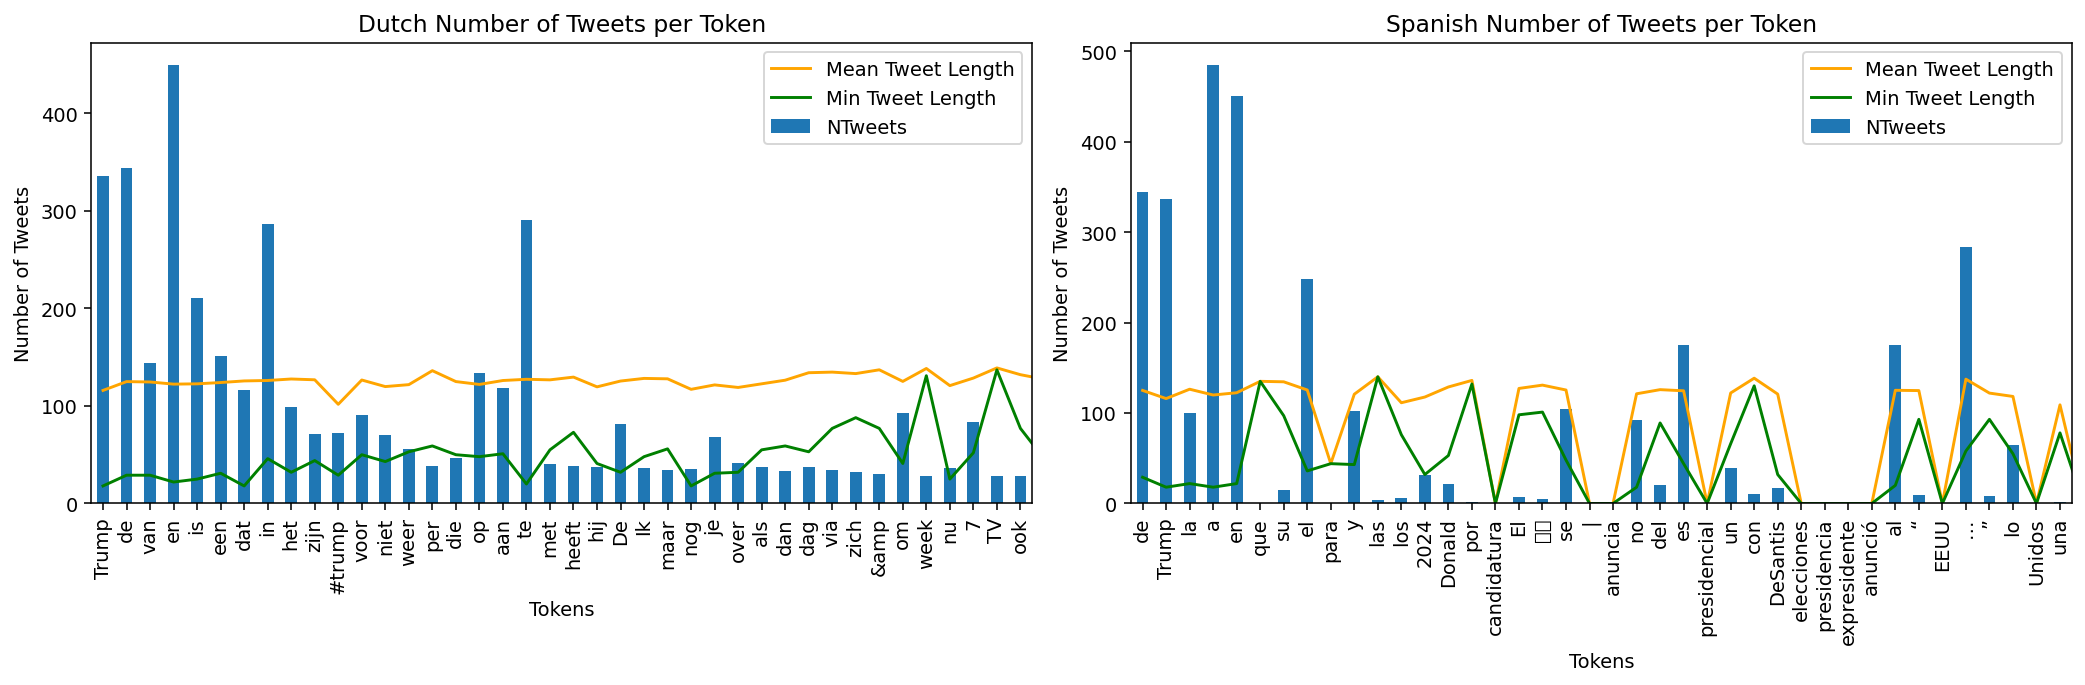

In [20]:
df = pd.DataFrame.from_dict(nlTokenFrequencies, orient='index', columns=["Token"]).sort_values(["Token"], ascending=False)
tweetsRow = []
meanLength = []
minLength = []
maxLength = []
for token in df.iterrows():
    token = token[0]
    tweetsRow.append(len([tweet for tweet in nlDF["text"] if token in tweet]))
    tweets = [len(tweet) for tweet in nlDF["text"] if token in tweet]
    if len(tweets) == 0:
        meanLength.append(0)
        minLength.append(0)
        maxLength.append(0)
    else:
        meanLength.append(np.mean(tweets))
        minLength.append(min(tweets))
        maxLength.append(max(tweets))
resdfnl = pd.DataFrame.from_dict({
    "Token": [token[0] for token in df.iterrows()],
    "NTweets": tweetsRow,
    "meanTweetlength": meanLength,
    "minTweetlength": minLength,
    "maxTweetLength": maxLength
})
df = pd.DataFrame.from_dict(esTokenFrequencies, orient='index', columns=["Token"]).sort_values(["Token"], ascending=False)
tweetsRow = []
meanLength = []
minLength = []
maxLength = []
for token in df.iterrows():
    token = token[0]
    tweetsRow.append(len([tweet for tweet in nlDF["text"] if token in tweet]))
    tweets = [len(tweet) for tweet in nlDF["text"] if token in tweet]
    if len(tweets) == 0:
        meanLength.append(0)
        minLength.append(0)
        maxLength.append(0)
    else:
        meanLength.append(np.mean(tweets))
        minLength.append(min(tweets))
        maxLength.append(max(tweets))
resdfes = pd.DataFrame.from_dict({
    "Token": [token[0] for token in df.iterrows()],
    "NTweets": tweetsRow,
    "meanTweetlength": meanLength,
    "minTweetlength": minLength,
    "maxTweetLength": maxLength
})

fig, axes = plt.subplots(1, 2, dpi=140, figsize=(15,5))
topN = 40

resdfnl[["Token","NTweets"]].head(topN).plot(kind='bar', ax=axes[0])
axes[0].plot(resdfnl["meanTweetlength"], label="Mean Tweet Length", color='orange')
axes[0].plot(resdfnl["minTweetlength"], label="Min Tweet Length", color='green')
axes[0].legend()
axes[0].set_title("Dutch Number of Tweets per Token")
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Number of Tweets")
axes[0].set_xticks(range(topN),labels=resdfnl["Token"].head(topN))

resdfes[["Token","NTweets"]].head(topN).plot(kind='bar', ax=axes[1])
axes[1].plot(resdfes["meanTweetlength"], label="Mean Tweet Length", color='orange')
axes[1].plot(resdfes["minTweetlength"], label="Min Tweet Length", color='green')
axes[1].legend()
axes[1].set_title("Spanish Number of Tweets per Token")
axes[1].set_xlabel("Tokens")
axes[1].set_ylabel("Number of Tweets")
axes[1].set_xticks(range(topN),labels=resdfes["Token"].head(topN))

plt.rcParams['savefig.facecolor']='white'
plt.tight_layout()
plt.savefig("./plots/Tweetspertoken.png",dpi=400, bbox_inches='tight')

New lets do the same thing for lemmas

/tmp/ipykernel_70310/2342496964.py:72: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/2342496964.py:72: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_70310/2342496964.py:73: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.savefig("./plots/Tweetsperlemma.png",dpi=400, bbox_inches='tight')
/tmp/ipykernel_70310/2342496964.py:73: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.savefig("./plots/Tweetsperlemma.png",dpi=400, bbox_inches='tight')
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/revess/anaconda3/envs/LaD/lib/python3.8/site-p

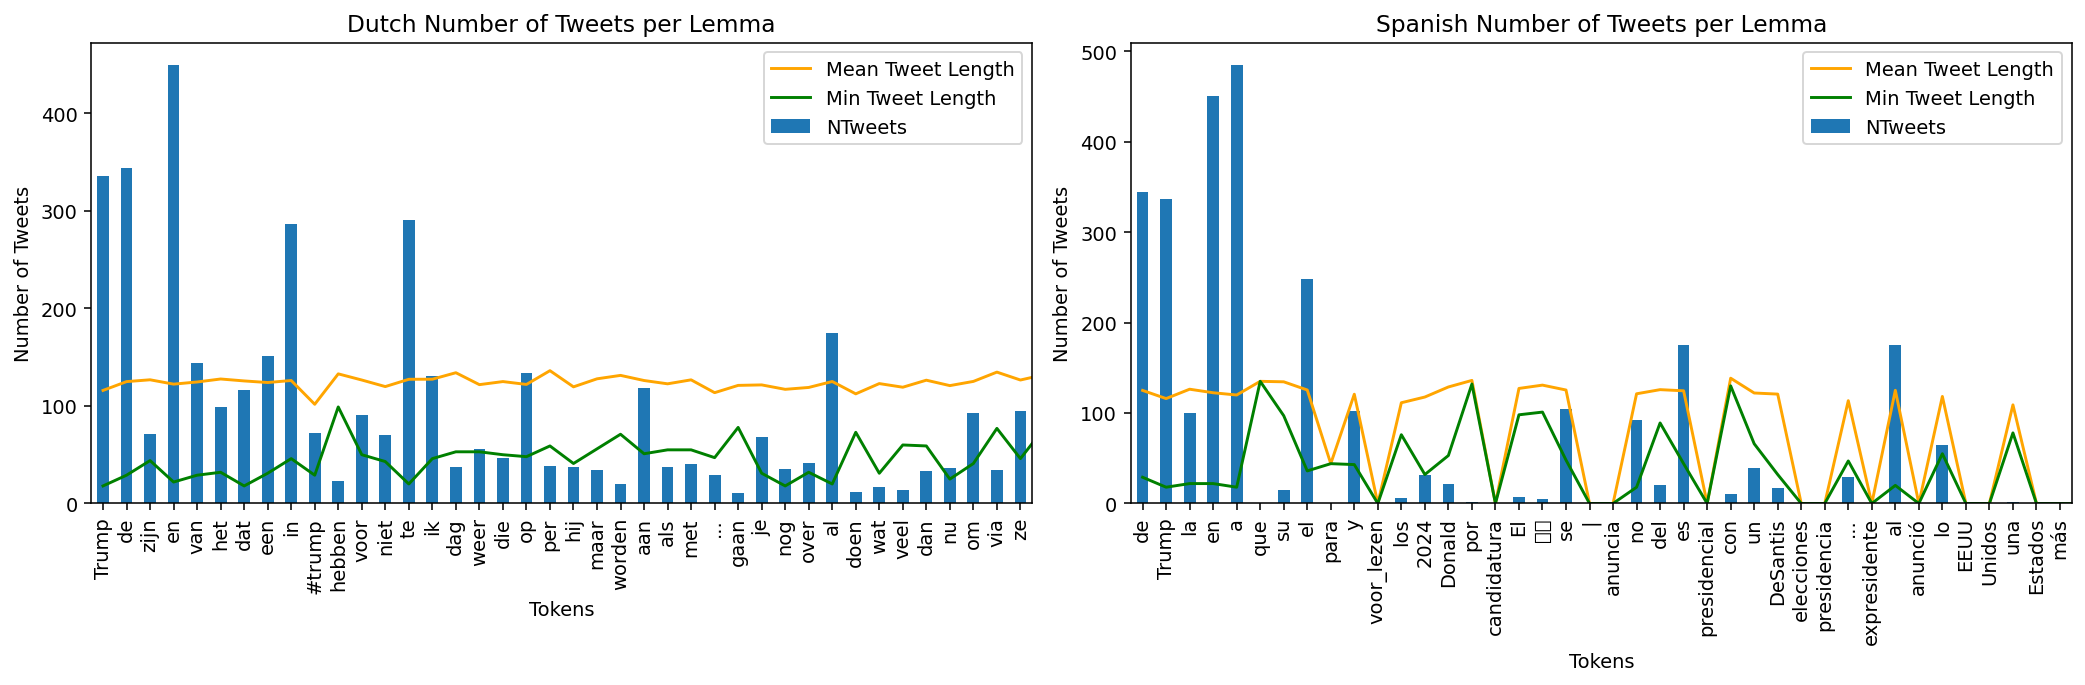

In [21]:
df = pd.DataFrame.from_dict(nlLemmaFrequencies, orient='index', columns=["Token"]).sort_values(["Token"], ascending=False)
tweetsRow = []
meanLength = []
minLength = []
maxLength = []
for token in df.iterrows():
    token = token[0]
    tweetsRow.append(len([tweet for tweet in nlDF["text"] if token in tweet]))
    tweets = [len(tweet) for tweet in nlDF["text"] if token in tweet]
    if len(tweets) == 0:
        meanLength.append(0)
        minLength.append(0)
        maxLength.append(0)
    else:
        meanLength.append(np.mean(tweets))
        minLength.append(min(tweets))
        maxLength.append(max(tweets))
resdfnl = pd.DataFrame.from_dict({
    "Token": [token[0] for token in df.iterrows()],
    "NTweets": tweetsRow,
    "meanTweetlength": meanLength,
    "minTweetlength": minLength,
    "maxTweetLength": maxLength
})
df = pd.DataFrame.from_dict(esLemmaFrequencies, orient='index', columns=["Token"]).sort_values(["Token"], ascending=False)
tweetsRow = []
meanLength = []
minLength = []
maxLength = []
for token in df.iterrows():
    token = token[0]
    tweetsRow.append(len([tweet for tweet in nlDF["text"] if token in tweet]))
    tweets = [len(tweet) for tweet in nlDF["text"] if token in tweet]
    if len(tweets) == 0:
        meanLength.append(0)
        minLength.append(0)
        maxLength.append(0)
    else:
        meanLength.append(np.mean(tweets))
        minLength.append(min(tweets))
        maxLength.append(max(tweets))
resdfes = pd.DataFrame.from_dict({
    "Token": [token[0] for token in df.iterrows()],
    "NTweets": tweetsRow,
    "meanTweetlength": meanLength,
    "minTweetlength": minLength,
    "maxTweetLength": maxLength
})

fig, axes = plt.subplots(1, 2, dpi=140, figsize=(15,5))
topN = 40

resdfnl[["Token","NTweets"]].head(topN).plot(kind='bar', ax=axes[0])
axes[0].plot(resdfnl["meanTweetlength"], label="Mean Tweet Length", color='orange')
axes[0].plot(resdfnl["minTweetlength"], label="Min Tweet Length", color='green')
axes[0].legend()
axes[0].set_title("Dutch Number of Tweets per Lemma")
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Number of Tweets")
axes[0].set_xticks(range(topN),labels=resdfnl["Token"].head(topN))

resdfes[["Token","NTweets"]].head(topN).plot(kind='bar', ax=axes[1])
axes[1].plot(resdfes["meanTweetlength"], label="Mean Tweet Length", color='orange')
axes[1].plot(resdfes["minTweetlength"], label="Min Tweet Length", color='green')
axes[1].legend()
axes[1].set_title("Spanish Number of Tweets per Lemma")
axes[1].set_xlabel("Tokens")
axes[1].set_ylabel("Number of Tweets")
axes[1].set_xticks(range(topN),labels=resdfes["Token"].head(topN))

plt.rcParams['savefig.facecolor']='white'
plt.tight_layout()
plt.savefig("./plots/Tweetsperlemma.png",dpi=400, bbox_inches='tight')